<a href="https://colab.research.google.com/github/Farha00/image_and_video_search/blob/main/extraction_layout_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q faiss-cpu transformers timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import torch
import faiss
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel

In [ ]:
doc_corpus_dir = "/content/drive/MyDrive/extracted_figures_lp/doc1"
query_dir = "/content/drive/MyDrive/images_search/search input/140.png"
output_dir = "/content/drive/MyDrive/images_search/extracted_lp_retrieved"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
model.eval()

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [ ]:
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        # Ensure the image is resized to the expected input size for the model
        inputs = processor(images=image, return_tensors="pt", do_resize=True, size={"shortest_edge": 224, "longest_edge": 224})
        return inputs["pixel_values"].squeeze(0)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error loading {image_path}: {e}")
        return None


In [ ]:
doc_paths = []
doc_features = []

for filename in tqdm(os.listdir(doc_corpus_dir)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(doc_corpus_dir, filename)
        pixel_values = preprocess_image(path)
        if pixel_values is not None:
            with torch.no_grad():
                outputs = model(pixel_values.unsqueeze(0).to(device))
                feature = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
                doc_features.append(feature)
                doc_paths.append(path)

if not doc_features:
    raise ValueError("No valid images found in the document corpus.")

doc_features = np.stack(doc_features).astype('float32')

100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


In [ ]:
index = faiss.IndexFlatL2(doc_features.shape[1])
index.add(doc_features)

In [ ]:
def cosine_similarity(a, b):
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(b_norm, a_norm)

# Removed the loop and directory listing
print(f"🔎 Processing query {os.path.basename(query_dir)} and retrieving top 3 matches...")

query_path = query_dir # query_dir is already the path to the single image

pixel_values = preprocess_image(query_path)

if pixel_values is not None:
    with torch.no_grad():
        q_embedding = model(pixel_values.unsqueeze(0).to(device)).last_hidden_state[:, 0, :]
        q_feature = q_embedding.squeeze(0).cpu().numpy().astype('float32')

    # Search top-3 using L2, then compute cosine similarity
    k = 3
    # The query feature needs to be a 2D array for faiss.search, even if it's a single vector
    D, I = index.search(np.expand_dims(q_feature, axis=0), k)
    top3_indices = I[0] # Get the indices of the top 3 results
    top3_paths = [doc_paths[i] for i in top3_indices]
    top3_features = doc_features[top3_indices]
    top3_similarities = cosine_similarity(q_feature, top3_features)

    # Show and save images side by side
    fig, axes = plt.subplots(1, k + 1, figsize=(18, 6))
    images_to_show = [query_path] + top3_paths
    titles = ['Query'] + [f"Top-{i+1}\nSim: {top3_similarities[i]:.4f}" for i in range(k)]

    for ax, img_path, title in zip(axes, images_to_show, titles):
        try:
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        except (UnidentifiedImageError, OSError) as e:
            print(f"Error displaying image {img_path}: {e}")
            ax.set_title(f"Error loading {os.path.basename(img_path)}")
            ax.axis('off')


    plt.tight_layout()
    # Use the base name of the query image for the output file name
    query_basename = os.path.splitext(os.path.basename(query_path))[0]
    save_path = os.path.join(output_dir, f"result_{query_basename}.png")
    plt.savefig(save_path)
    plt.close()

    # Print similarity values
    print(f"\nQuery: {os.path.basename(query_path)}")
    for i, (img_path, sim_score) in enumerate(zip(top3_paths, top3_similarities)):
        print(f"Top-{i+1}: {os.path.basename(img_path)} | Cosine Similarity: {sim_score:.4f}")
else:
    print(f"Could not process query image: {query_path}")

🔎 Processing query 140.png and retrieving top 3 matches...

Query: 140.png
Top-1: page_11_figure_1.png | Cosine Similarity: 0.9789
Top-2: page_12_figure_1.png | Cosine Similarity: 0.7474
Top-3: page_20_figure_1.png | Cosine Similarity: 0.6698


In [ ]:
!pip install pytesseract pillow

In [ ]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
def preprocess_image_for_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Converts to grayscale
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)  # Resize image
    gray = cv2.medianBlur(gray, 3)  # Reduces noise
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)  # Enhance text
    return gray

In [ ]:
import pytesseract
from PIL import Image

# Open the image file
image = Image.open('/content/drive/MyDrive/images_search/search input/101.png')

# Perform OCR using PyTesseract
text = pytesseract.image_to_string(image)

# Print the extracted text
print(text)

 
 

FESOV FET ouput Gnd

 
 
 
     
 

   

cca) FET Ouput ond

   

ipl aor

  
    

(ISOV_FET ouput Ona

 
  
 
 
 

Fee Opce Fst

   
   

 
  

 

meagan

een Stny

 

 
 
   

   
  
   

FeTope Cow
reemacxhocesing

   
   

FET. CMET Cot den)

neal

RISOV FET Ouput Cnet

 
 

FeIMata FET Cr raed

  

SFC Rataie Cane
Ca nde

 
  

      
  

Pawntor FET Output Cn
Pawsolena FET Gua, Gd

  
  

  

    
 

‘Sip Transom

 
 

 
   
 
   
 

D0AG FET Oupt ond

anor

    



In [2]:
!pip install poppler-utils
!pip install tesseract-ocr-eng
!pip install layoutparser torchvision
!pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2img
!pip install "layoutparser[ocr]"

ERROR: Could not find a version that satisfies the requirement tesseract-ocr-eng (from versions: none)
ERROR: No matching distribution found for tesseract-ocr-eng
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:0

In [1]:
!apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (391 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
!pip uninstall -y Pillow

!pip install Pillow==9.5.0

Found existing installation: pillow 11.2.1
Uninstalling pillow-11.2.1:
  Successfully uninstalled pillow-11.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [1]:
import numpy as np
# Import the pdf2image module
import pdf2image
import layoutparser as lp

In [ ]:
pdf_file= '/content/drive/MyDrive/doc-26-27.pdf'
img = np.asarray(pdf2image.convert_from_path(pdf_file)[0])

model1 = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

model2 = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

model3 = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

model4 = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

layout_result1 = model1.detect(img)
layout_result2 = model2.detect(img)
layout_result3 = model3.detect(img)
layout_result4 = model4.detect(img)

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


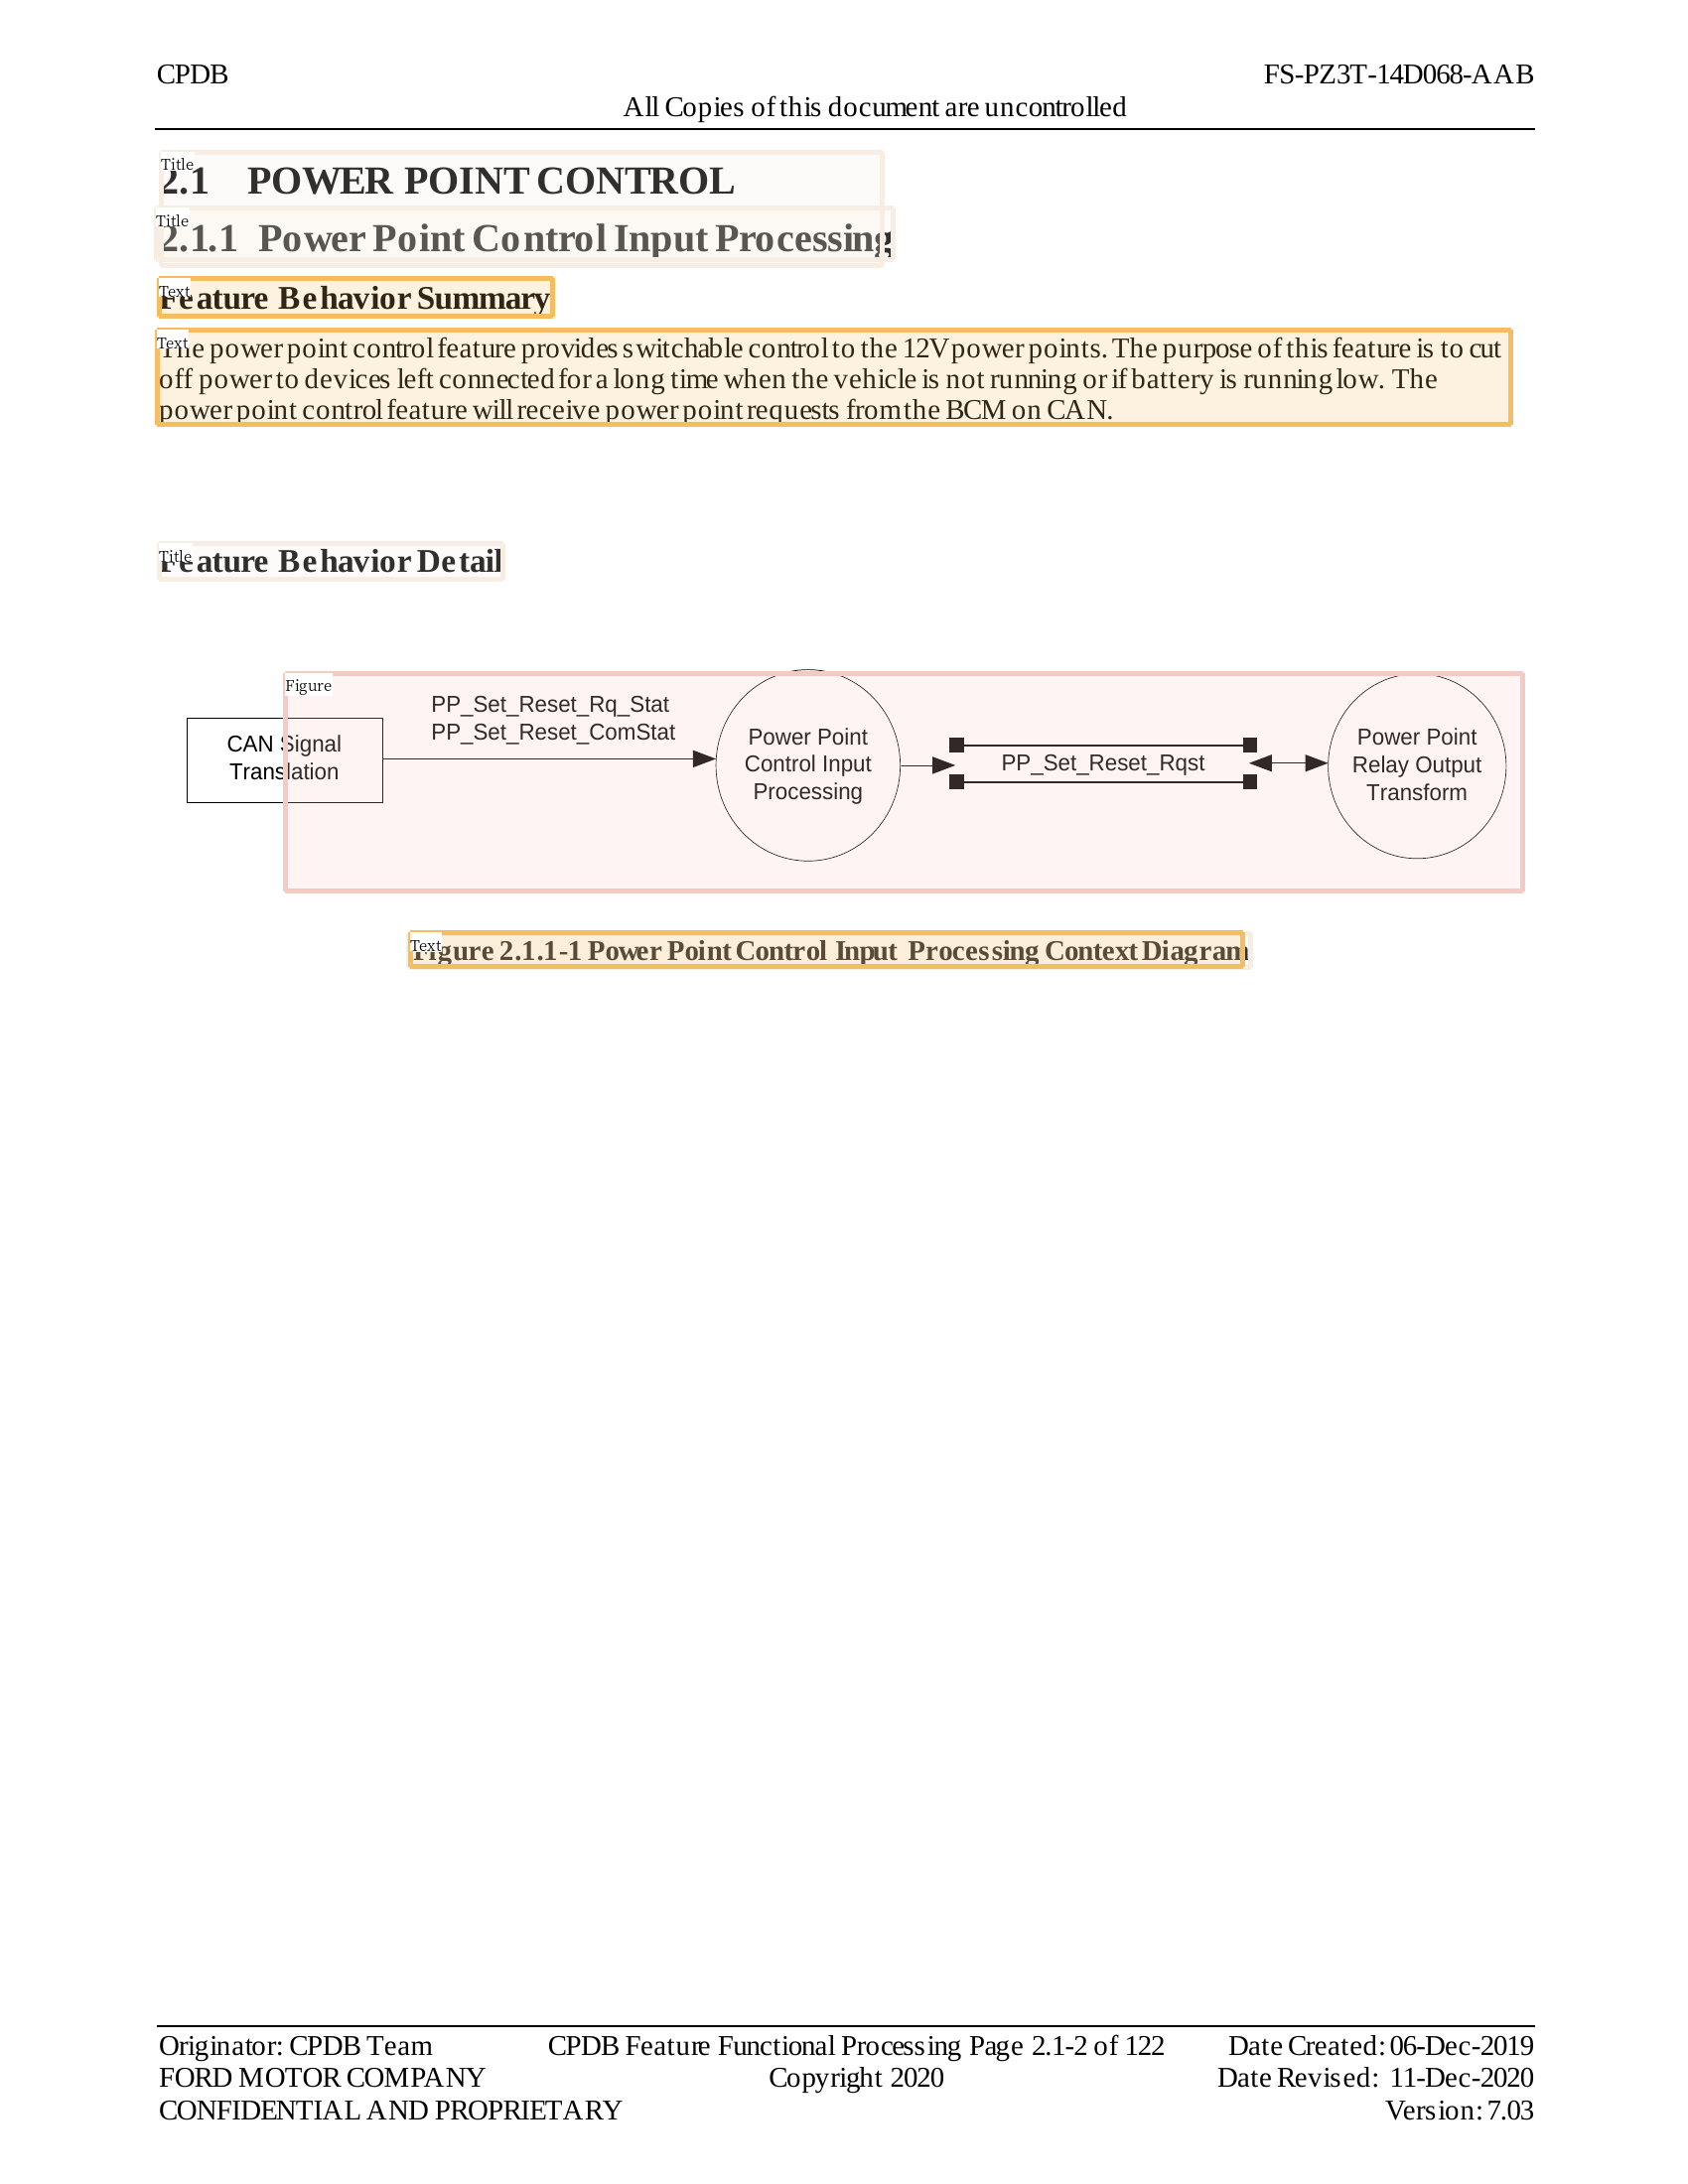

In [ ]:

lp.draw_box(img, layout_result1,  box_width=5, box_alpha=0.2, show_element_type=True)


In [ ]:
import cv2

In [ ]:
figure_blocks = [b for b in layout_result1 if b.type == "Figure"]

import os
os.makedirs("figures", exist_ok=True)

for idx, block in enumerate(figure_blocks):
    x1, y1, x2, y2 = map(int, block.coordinates)
    cropped = img[y1:y2, x1:x2]
    filename = f"figures/figure_{idx+1}.png"
    cv2.imwrite(filename, cropped)
    print(f"Saved: {filename}")


Saved: figures/figure_1.png


  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


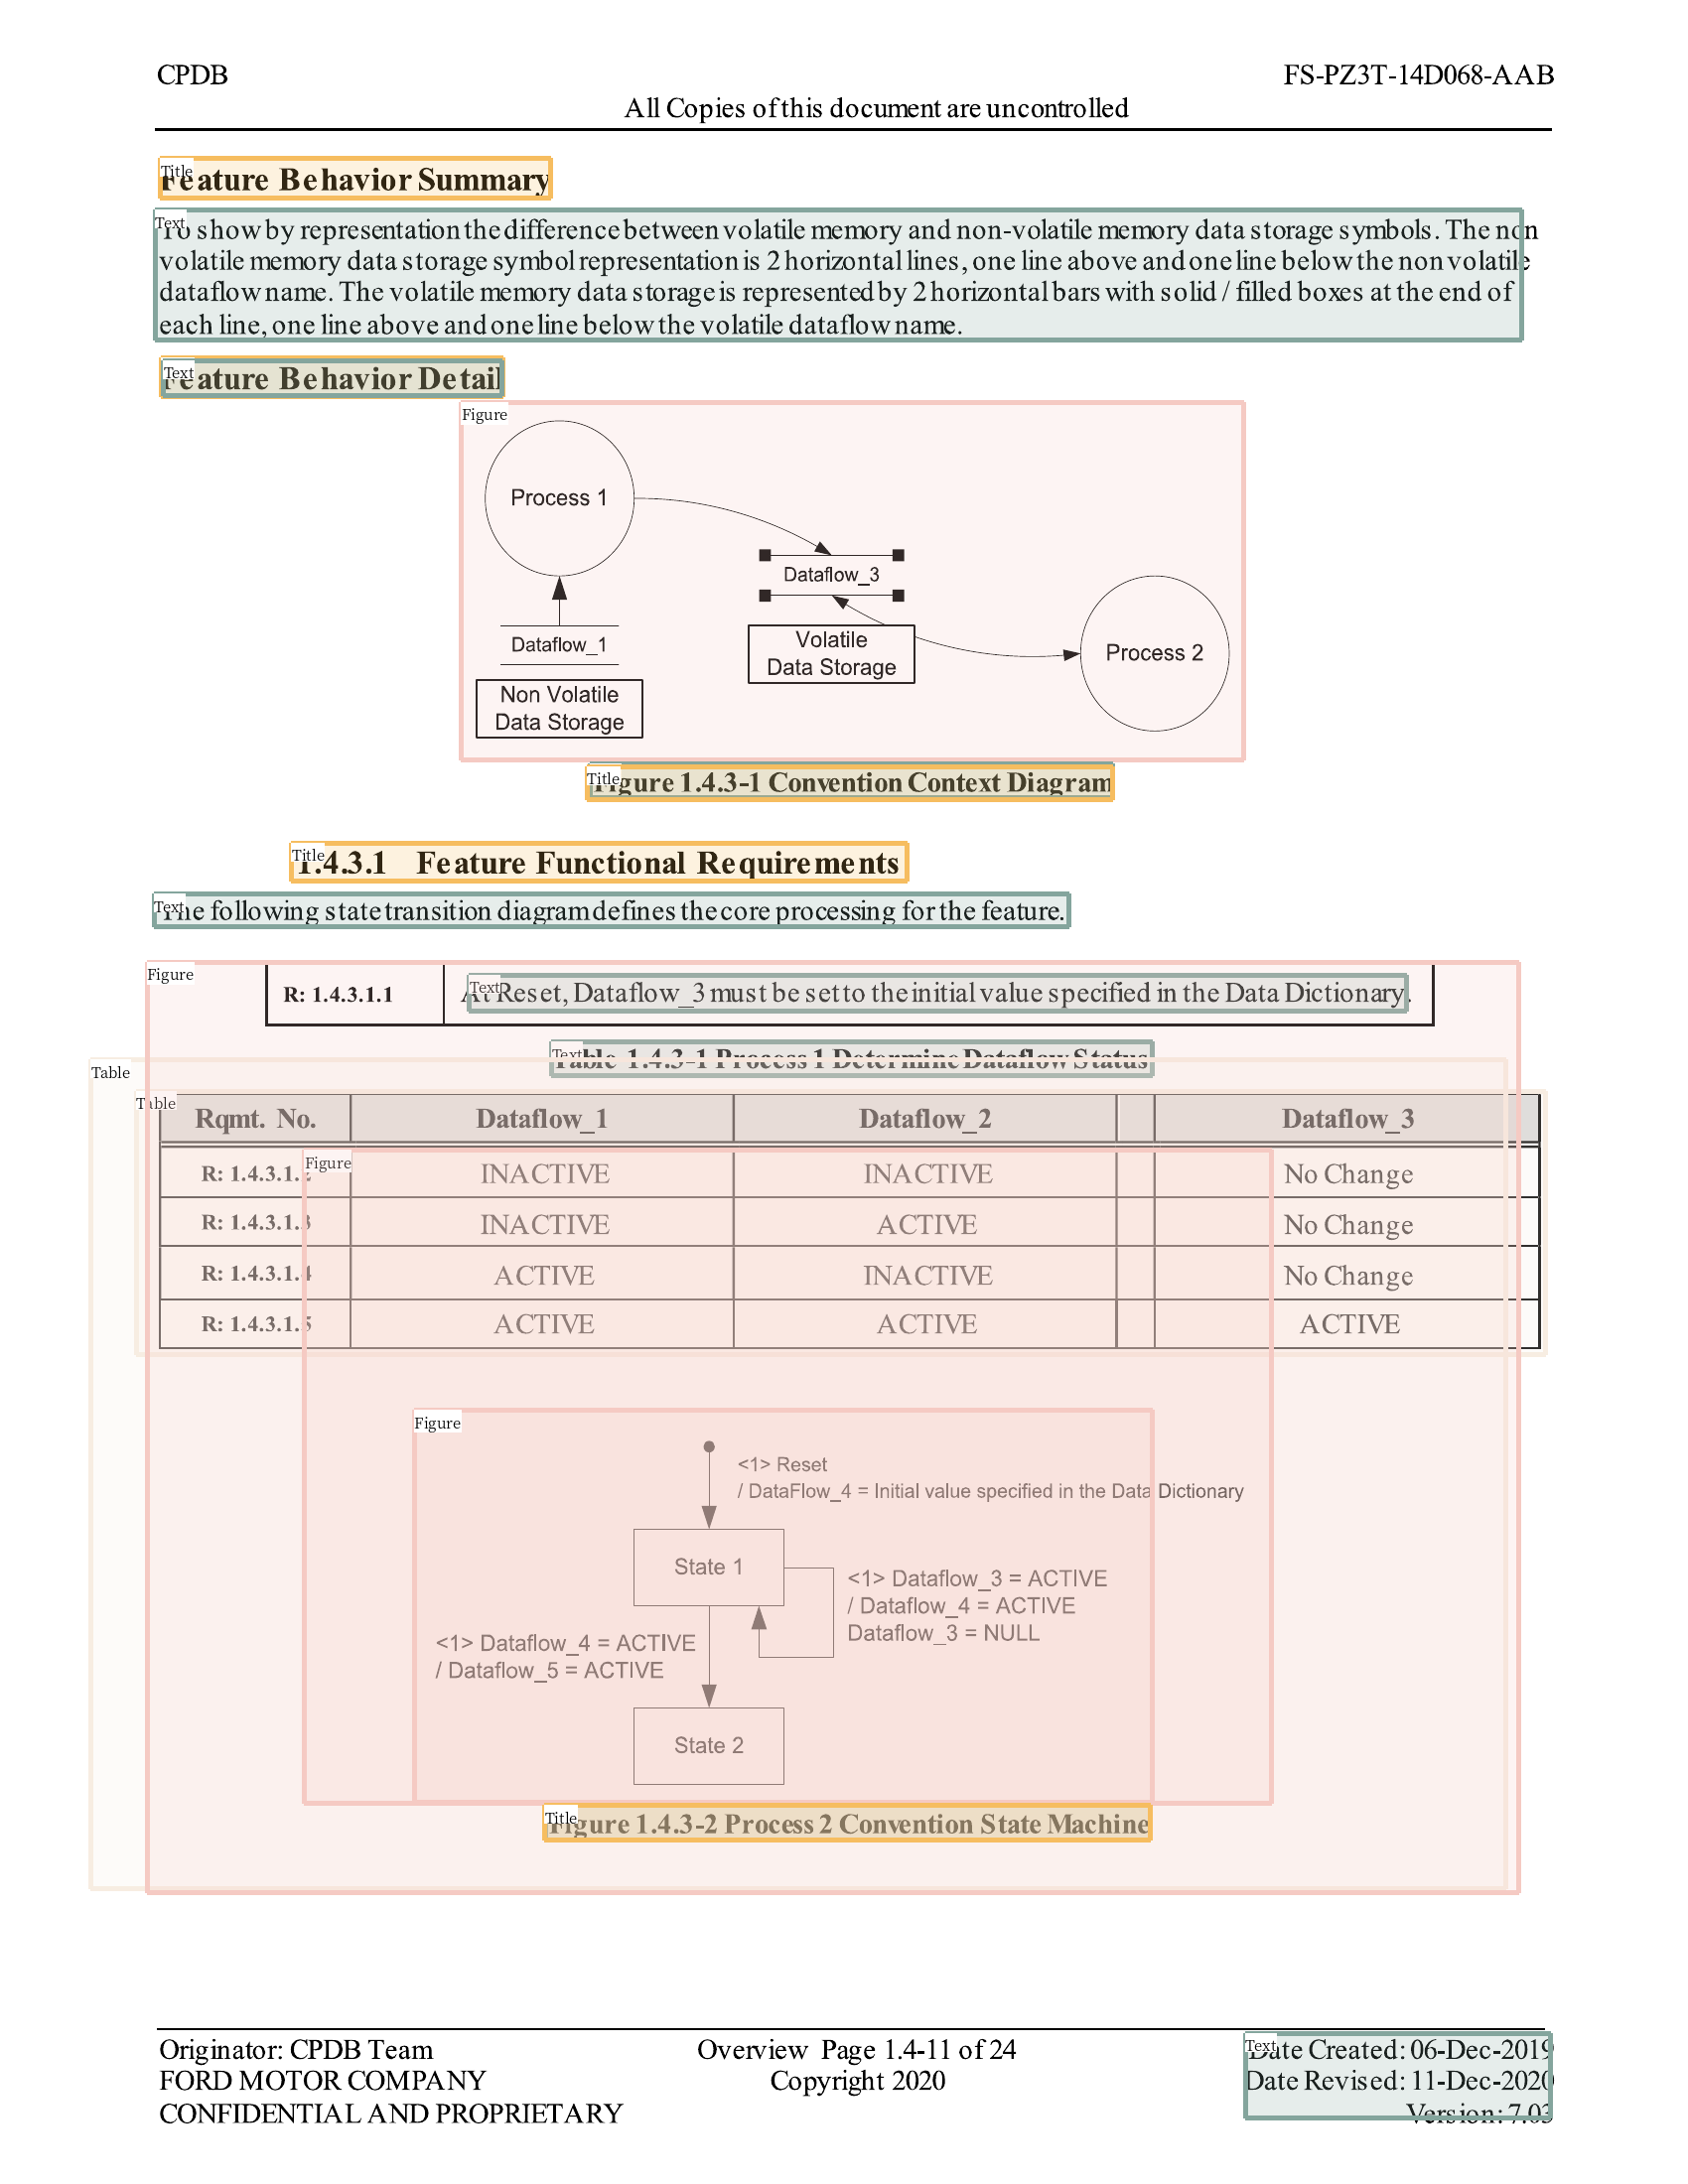

In [ ]:
pdf_file= '/content/drive/MyDrive/sample1.pdf'
img = np.asarray(pdf2image.convert_from_path(pdf_file)[0])

model1 = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.1],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

layout_result1 = model1.detect(img)
lp.draw_box(img, layout_result1,  box_width=5, box_alpha=0.2, show_element_type=True)



In [ ]:
figure_blocks = [b for b in layout_result1 if b.type == "Figure"]
import os
os.makedirs("figures", exist_ok=True)

for idx, block in enumerate(figure_blocks):
    x1, y1, x2, y2 = map(int, block.coordinates)
    cropped = img[y1:y2, x1:x2]
    filename = f"figures/figure3_{idx+1}.png"
    cv2.imwrite(filename, cropped)
    print(f"Saved: {filename}")


Saved: figures/figure3_1.png
Saved: figures/figure3_2.png
Saved: figures/figure3_3.png
Saved: figures/figure3_4.png


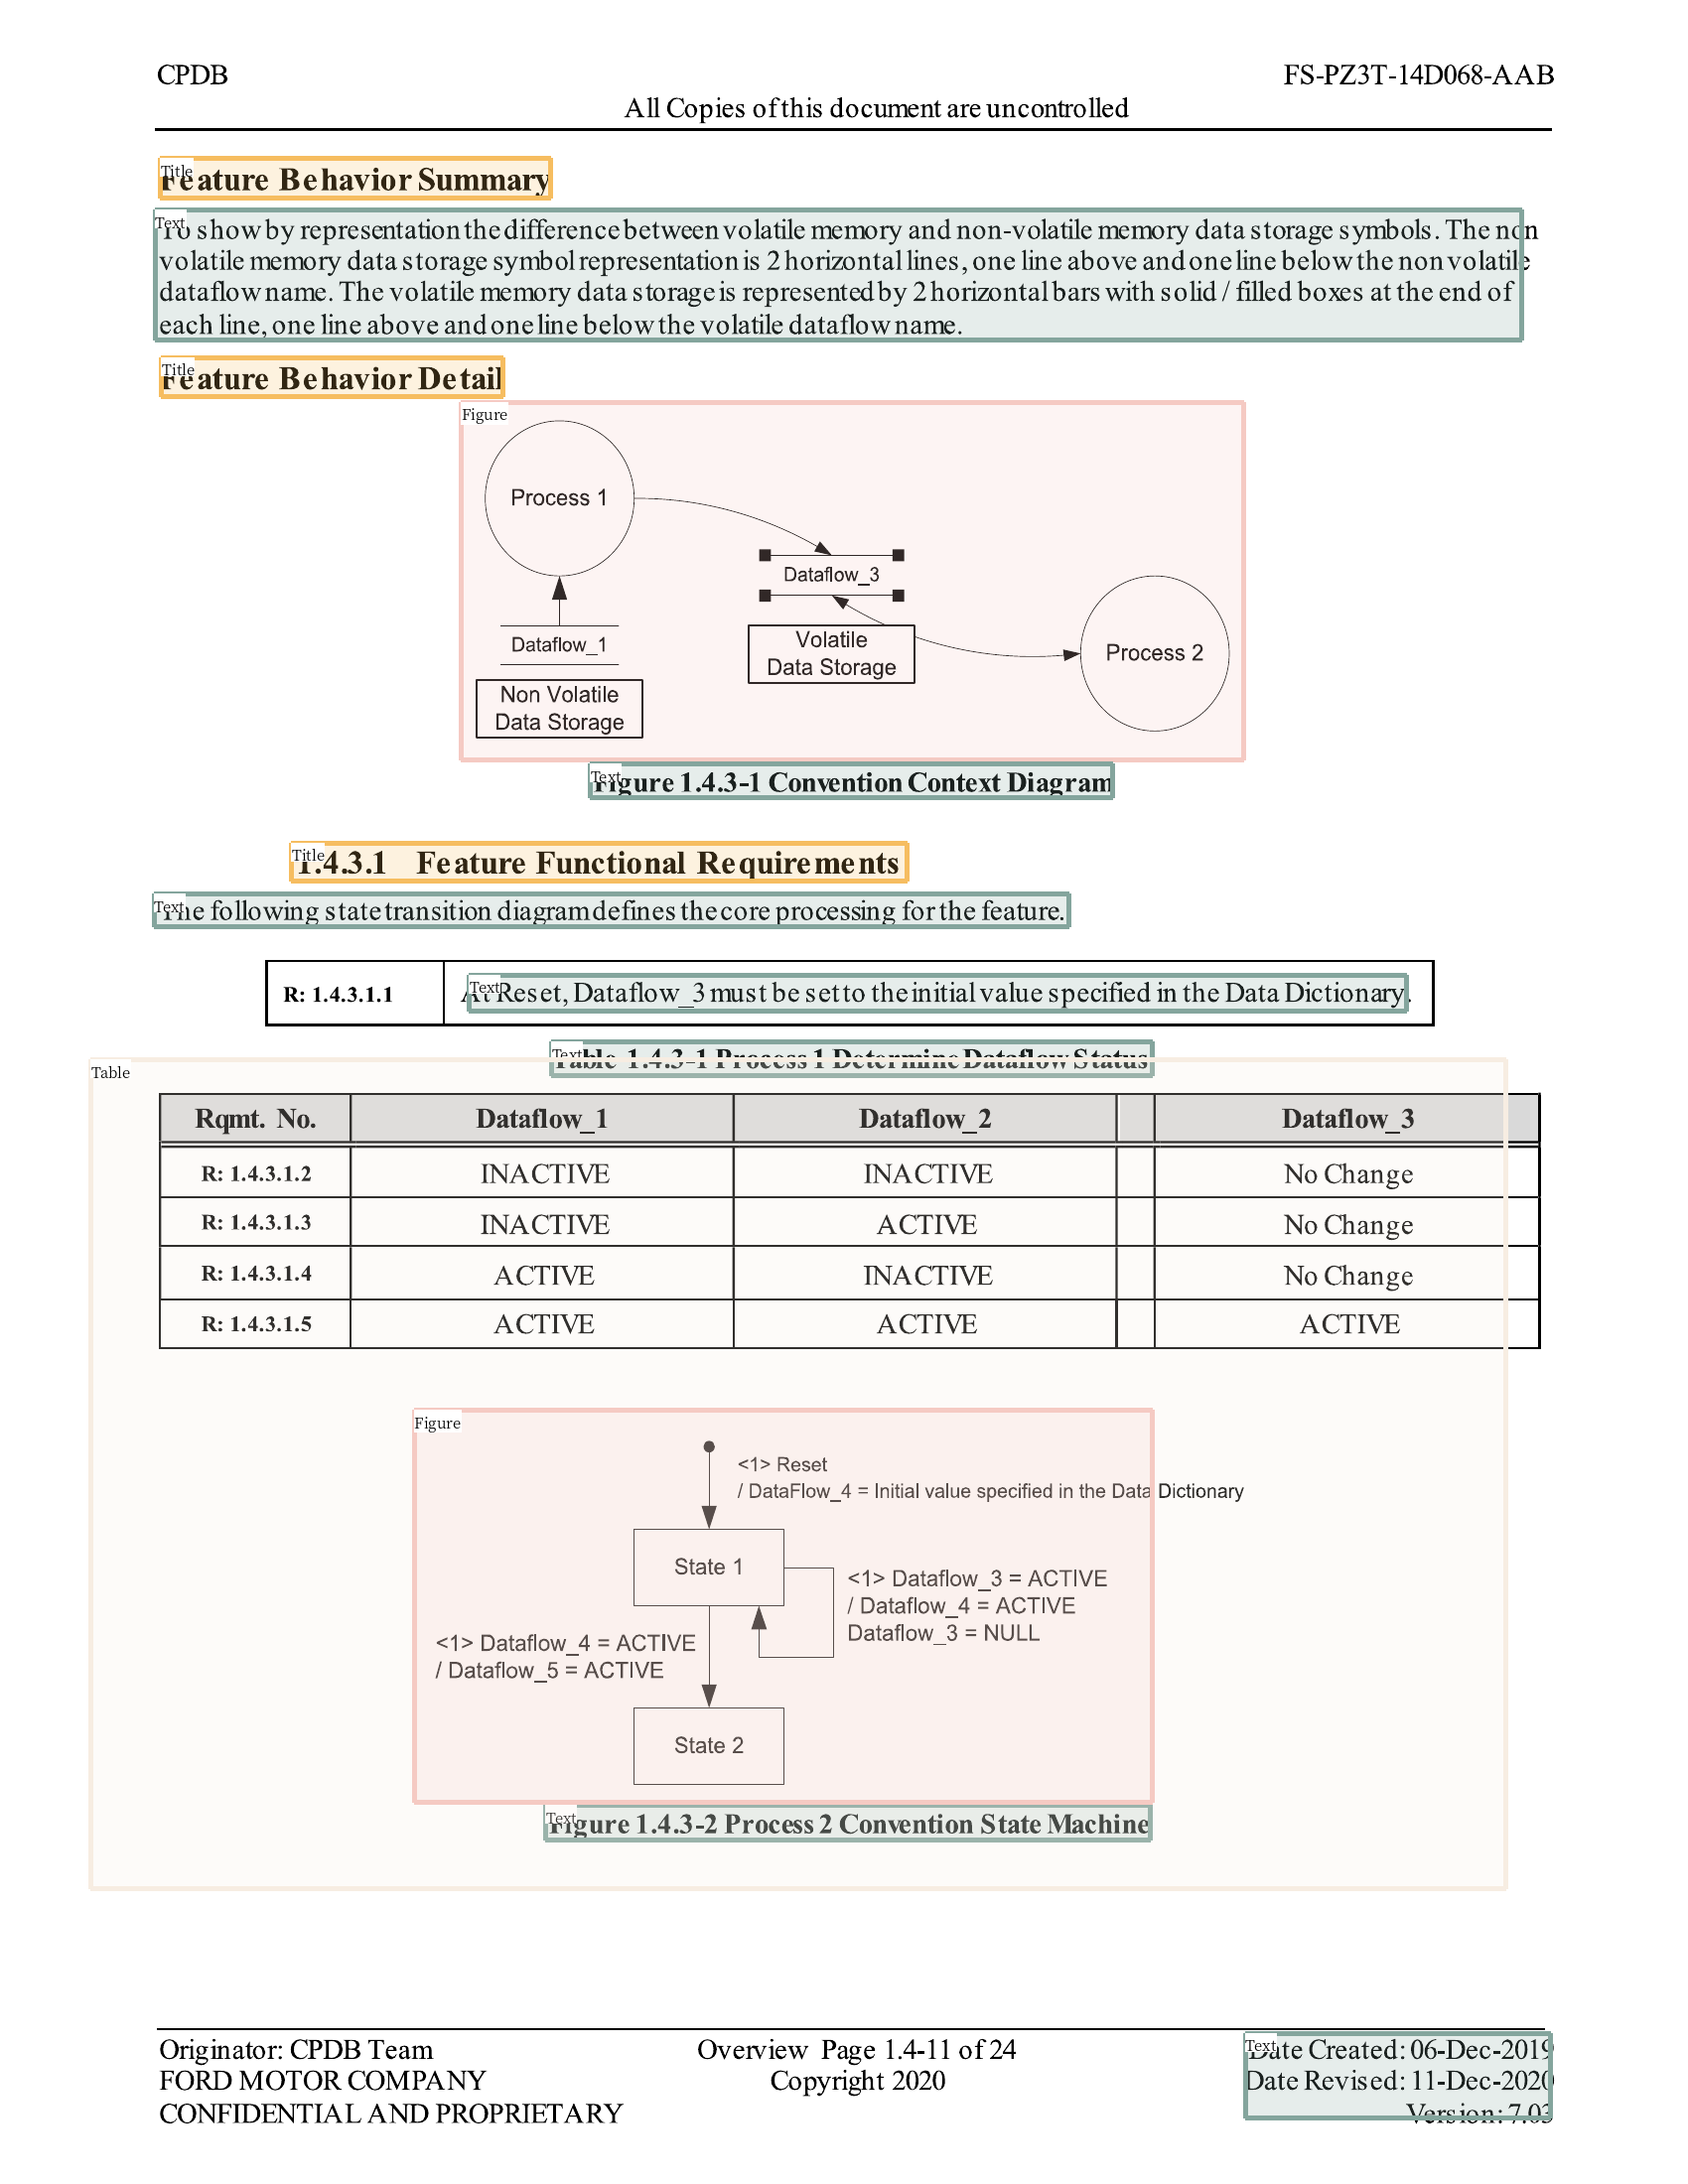

In [ ]:
import torch
from torchvision.ops import nms

# Step 1: Convert layout_result1 into boxes and scores
boxes = []
scores = []

for el in layout_result1:
    x1, y1, x2, y2 = el.block.x_1, el.block.y_1, el.block.x_2, el.block.y_2
    boxes.append([x1, y1, x2, y2])
    scores.append(el.score)  # confidence score

boxes = torch.tensor(boxes, dtype=torch.float32)
scores = torch.tensor(scores)

# Step 2: Apply NMS
keep_indices = nms(boxes, scores, iou_threshold=0.3)

# Step 3: Filter original layout_result1
filtered_result = [layout_result1[i] for i in keep_indices]

# Optional: Visualize filtered results
lp.draw_box(img, filtered_result, box_width=5, box_alpha=0.2, show_element_type=True)


In [ ]:
figure_blocks = [b for b in filtered_result if b.type == "Figure"]
import os
os.makedirs("figures", exist_ok=True)

for idx, block in enumerate(figure_blocks):
    x1, y1, x2, y2 = map(int, block.coordinates)
    cropped = img[y1:y2, x1:x2]
    filename = f"figures/figurenms_{idx+1}.png"
    cv2.imwrite(filename, cropped)
    print(f"Saved: {filename}")


Saved: figures/figurenms_1.png
Saved: figures/figurenms_2.png


In [2]:
from torchvision.ops import nms
import os
import numpy as np
import torch
import cv2
import pdf2image
import layoutparser as lp


In [ ]:
# prompt: parse over an entire pdf, extract the figures and save the figures in a folder

# Function to process a single PDF file
def process_pdf_and_extract_figures(pdf_path, output_base_dir):


    try:
        # Create a directory for the figures from this specific PDF
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
        output_dir_pdf = os.path.join(output_base_dir, pdf_name)
        os.makedirs(output_dir_pdf, exist_ok=True)
        print(f"Processing PDF: {pdf_path}")

        # Convert PDF pages to images
        pages = pdf2image.convert_from_path(pdf_path)
        print(f"Converted {len(pages)} pages to images.")

        # Use the previously defined model
        model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                         extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                         label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

        figure_count = 0
        for page_num, page_img in enumerate(pages):
            print(f"Analyzing page {page_num + 1}...")
            # Convert PIL image to numpy array for LayoutParser and OpenCV
            img_np = np.asarray(page_img.convert('RGB')) # Ensure RGB

            # Detect layout on the page
            layout_result = model.detect(img_np)

            # Filter for figure blocks
            figure_blocks = [b for b in layout_result if b.type == "Figure"]

            # Apply NMS to figure blocks (optional but good for overlapping detections)
            if figure_blocks:
              boxes = []
              scores = []
              for el in figure_blocks:
                  x1, y1, x2, y2 = el.block.x_1, el.block.y_1, el.block.x_2, el.block.y_2
                  boxes.append([x1, y1, x2, y2])
                  scores.append(el.score)

              boxes = torch.tensor(boxes, dtype=torch.float32)
              scores = torch.tensor(scores)

              # Use a lower IoU threshold for figures if they might slightly overlap
              keep_indices = nms(boxes, scores, iou_threshold=0.3)
              figure_blocks_filtered = [figure_blocks[i] for i in keep_indices]
            else:
              figure_blocks_filtered = []


            # Save each detected figure
            for idx, block in enumerate(figure_blocks_filtered):
                x1, y1, x2, y2 = map(int, block.coordinates)
                # Ensure coordinates are within image bounds
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(img_np.shape[1], x2)
                y2 = min(img_np.shape[0], y2)

                if x2 > x1 and y2 > y1: # Ensure valid crop area
                  cropped = img_np[y1:y2, x1:x2]
                  figure_count += 1
                  filename = os.path.join(output_dir_pdf, f"page_{page_num + 1}_figure_{idx+1}.png")
                  # Convert cropped image from RGB to BGR for cv2.imwrite
                  cv2.imwrite(filename, cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
                  # print(f"Saved: {filename}") # Optional: print for every figure
                else:
                  print(f"Skipping invalid crop area on page {page_num + 1} for block {idx+1}: ({x1}, {y1}) to ({x2}, {y2})")

        print(f"Finished processing {pdf_path}. Extracted {figure_count} figures to {output_dir_pdf}")

    except Exception as e:
        print(f"An error occurred while processing {pdf_path}: {e}")


# --- Main script to process a list of PDF files ---

# Define the directory containing the PDF files
pdf_corpus_dir = "/content/drive/MyDrive/doc_samples/d7.pdf" # CHANGE THIS to your PDF directory
output_figures_base_dir = "/content/drive/MyDrive/extracted_figures_layoutp" # CHANGE THIS to where you want to save figures

os.makedirs(output_figures_base_dir, exist_ok=True)

# Get a list of all PDF files in the directory
# The current pdf_corpus_dir is a file, not a directory.
# Check if the path is a directory or a file
if os.path.isdir(pdf_corpus_dir):
    pdf_files = [os.path.join(pdf_corpus_dir, f) for f in os.listdir(pdf_corpus_dir) if f.lower().endswith('.pdf')]
elif os.path.isfile(pdf_corpus_dir) and pdf_corpus_dir.lower().endswith('.pdf'):
    pdf_files = [pdf_corpus_dir]
else:
    pdf_files = []
    print(f"Provided path is not a valid directory or PDF file: {pdf_corpus_dir}")


if not pdf_files:
    print(f"No PDF files found in {pdf_corpus_dir}")
else:
    print(f"Found {len(pdf_files)} PDF files to process.")
    for pdf_file in pdf_files:
        process_pdf_and_extract_figures(pdf_file, output_figures_base_dir)

print("\nFigure extraction complete for all PDFs.")

Found 1 PDF files to process.
Processing PDF: /content/drive/MyDrive/doc_samples/d7.pdf
Converted 100 pages to images.


config.yaml?dl=1: 8.19kB [00:01, 6.33kB/s]
model_final.pth?dl=1: 856MB [00:21, 40.2MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Analyzing page 1...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Analyzing page 2...
Analyzing page 3...
Analyzing page 4...
Analyzing page 5...
Analyzing page 6...
Analyzing page 7...
Analyzing page 8...
Analyzing page 9...
Analyzing page 10...
Analyzing page 11...
Analyzing page 12...
Analyzing page 13...
Analyzing page 14...
Analyzing page 15...
Analyzing page 16...
Analyzing page 17...
Analyzing page 18...
Analyzing page 19...
Analyzing page 20...
Analyzing page 21...
Analyzing page 22...
Analyzing page 23...
Analyzing page 24...
Analyzing page 25...
Analyzing page 26...
Analyzing page 27...
Analyzing page 28...
Analyzing page 29...
Analyzing page 30...
Analyzing page 31...
Analyzing page 32...
Analyzing page 33...
Analyzing page 34...
Analyzing page 35...
Analyzing page 36...
Analyzing page 37...
Analyzing page 38...
Analyzing page 39...
Analyzing page 40...
Analyzing page 41...
Analyzing page 42...
Analyzing page 43...
Analyzing page 44...
Analyzing page 45...
Analyzing page 46...
Analyzing page 47...
Analyzing page 48...
Analyzing page 49...


In [1]:
!pip freeze >requirements.txt

In [1]:
!pip show layoutparser

Name: layoutparser
Version: 0.3.4
Summary: A unified toolkit for Deep Learning Based Document Image Analysis
Home-page: https://github.com/Layout-Parser/layout-parser
Author: Zejiang Shen, Ruochen Zhang, and Layout Parser Model Contributors
Author-email: layoutparser@gmail.com
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: iopath, numpy, opencv-python, pandas, pdf2image, pdfplumber, pillow, pyyaml, scipy
Required-by: 


In [5]:
!python -V

Python 3.11.13
